# Chapter 3: Binary classification problem

# Lab 3: Pokemon Combat Prediction

Trong bài Lab 3 này, mô hình dự đoán kết quả giao đấu Pokémon được triển khai theo hai kịch bản:

Kịch bản 1: Dùng kỹ thuật mã hoá số nguyên (integer encoding) để biểu diễn các thuộc tính của Pokémon khi huấn luyện mô hình, gọi là Model-1.

Kịch bản 2: Dùng kỹ thuật mã hoá one-hot (one-hot encoding) để biểu diễn các thuộc tính của Pokémon khi huấn luyện mô hình, gọi là Model-2.

Bộ dữ liệu Pokémon combat: https://www.kaggle.com/terminus7/pokemon-challenge

Các đặc trưng của mỗi Pokémon bao gồm:

Name: Tên Pokémon.

Type 1: Thuộc tính (hệ) thứ nhất.

Type 2: Thuộc tính (hệ) thứ hai.

HP: Máu (hitpoint).

Attack: Sức tấn công.

Defense: Sức phòng thủ.

Sp. Atk: Sức tấn công đặc biệt.

Sp. Def: Sức phòng thủ đặc biệt.

Speed: Tốc độ.

Generation: Thế hệ/đời tiến hoá.

Legendary: Pokémon huyền thoại.

# a) Import packages

In [59]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers


# b) Đọc và chuyển đổi dữ liệu
• Đọc dữ liệu Pokémon từ file CSV

In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("terminus7/pokemon-challenge")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pokemon-challenge' dataset.
Path to dataset files: /kaggle/input/pokemon-challenge


In [61]:
pokemon_df = pd.read_csv(os.path.join(path, 'pokemon.csv')) # read data pokemon_df.head()

In [62]:
pokemon_df = pokemon_df.set_index("#")
pokemon_df.head()


,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


• Đọc dữ liệu các trận đấu

In [63]:
combats_df = pd.read_csv(os.path.join(path, 'combats.csv'))
combats_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


Kiểm tra dữ liệu bị thiếu trong Pokémon data

In [64]:
pokemon_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB


Thuộc tính thứ hai (Type 2)

Thiết lập tham số dropna=False để tính cả dữ liệu bị thiếu (NaN). NaN nghĩa là Pokémon không có thuộc tính thứ hai.

In [65]:
pokemon_df["Type 2"].value_counts(dropna=False)
pokemon_df["Type 2"].fillna('empty', inplace=True)
pokemon_df["Type 2"].value_counts()


/tmp/ipython-input-2475725412.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pokemon_df["Type 2"].fillna('empty', inplace=True)


,count
Type 2,
empty,386
Flying,97
Ground,35
Poison,34
Psychic,33
Fighting,26
Grass,25
Fairy,23
Steel,22


• Kiểm tra kiểu dữ liệu

print(combats_df.dtypes)
print('-' * 30)
print(pokemon_df.dtypes)
pokemon_df['Type 1'] = pokemon_df['Type 1'].astype('category')  # Convert Type1 to category type
pokemon_df['Type 2'] = pokemon_df['Type 2'].astype('category')  # Convert Type2 to category type
pokemon_df['Legendary'] = pokemon_df['Legendary'].astype('int') # Convert Legendary to int data type
pokemon_df.dtypes


Dùng One-hot Encoding để biểu diễn thuộc tính (Type1 và Type2)

In [66]:
df_type1_one_hot = pd.get_dummies(pokemon_df['Type 1'])
df_type1_one_hot.head()
df_type2_one_hot = pd.get_dummies(pokemon_df['Type 2'])
df_type2_one_hot.head()
combine_df_one_hot = df_type1_one_hot.add(df_type2_one_hot, fill_value=0).astype('int64')
pd.options.display.max_columns = 30

# Identify columns in combine_df_one_hot that might overlap with pokemon_df
overlapping_columns = combine_df_one_hot.columns.intersection(pokemon_df.columns)

# Drop overlapping columns from pokemon_df if they exist
if not overlapping_columns.empty:
    pokemon_df.drop(columns=overlapping_columns, inplace=True)

pokemon_df = pokemon_df.join(combine_df_one_hot)
pokemon_df.head()

pokemon_df['Type 1'] = pokemon_df['Type 1'].astype('category')
pokemon_df['Type 2'] = pokemon_df['Type 2'].astype('category')

dict(enumerate(pokemon_df['Type 2'].cat.categories))
pokemon_df['Type 2'].cat.codes.head(10)
pokemon_df['Type 1'] = pokemon_df['Type 1'].cat.codes
pokemon_df['Type 2'] = pokemon_df['Type 2'].cat.codes
pokemon_df.head()
pokemon_df.drop('Name', axis='columns', inplace=True)
pokemon_df.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,13,45,49,49,65,65,45,1,False,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,9,13,60,62,63,80,80,60,1,False,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,9,13,80,82,83,100,100,80,1,False,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,9,13,80,100,123,122,120,80,1,False,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,18,39,52,43,60,50,65,1,False,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


• Chuẩn hoá nhãn Winner trong dữ liệu combat

Dùng 0 và 1 để biểu diễn người thắng:

0: Pokémon thứ nhất thắng

1: Pokémon thứ hai thắng

In [67]:
combats_df['Winner'] = combats_df.apply(
    lambda x: 0 if x.Winner == x.First_pokemon else 1,
    axis='columns'
)
combats_df.head()


,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0


# c) Chia dữ liệu

Chia dữ liệu combats thành 3 tập: train/validation/test theo tỉ lệ 6:2:2.

In [68]:
data_num = combats_df.shape[0]
indexes = np.random.permutation(data_num)

train_indexes = indexes[:int(data_num * 0.6)]
val_indexes   = indexes[int(data_num * 0.6):int(data_num * 0.8)]
test_indexes  = indexes[int(data_num * 0.8):]

train_data = combats_df.loc[train_indexes]
val_data   = combats_df.loc[val_indexes]
test_data  = combats_df.loc[test_indexes]
pokemon_df['Type 1'] = pokemon_df['Type 1'] / 19
pokemon_df['Type 2'] = pokemon_df['Type 2'] / 19
pokemon_df['Legendary'] = pokemon_df['Legendary'].astype('int') # Ensure Legendary is int
mean = pokemon_df.loc[:, 'HP':'Generation'].mean()
std  = pokemon_df.loc[:, 'HP':'Generation'].std()

pokemon_df.loc[:, 'HP':'Generation'] = (pokemon_df.loc[:, 'HP':'Generation'] - mean) / std
pokemon_df.head()
x_train_index = np.array(train_data.drop('Winner', axis='columns'))
x_val_index   = np.array(val_data.drop('Winner', axis='columns'))
x_test_index  = np.array(test_data.drop('Winner', axis='columns'))
y_train = np.array(train_data['Winner'])
y_val   = np.array(val_data['Winner'])
y_test  = np.array(test_data['Winner'])

/tmp/ipython-input-841936995.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.95003189 -0.36259526  0.42065358  0.42065358 -1.18500655 -0.44092015
  0.3423287   0.3423287   0.3423287  -0.98919434 -0.4017577   0.38149114
  0.38149114 -0.95003189 -0.75421968 -0.36259526 -1.14584411 -0.95003189
 -0.16678305 -0.16678305 -1.14584411 -0.24510794  0.53814091  0.53814091
 -1.53746853 -0.55840747 -1.14584411 -0.16678305 -1.34165632 -0.36259526
 -1.34165632 -0.36259526 -0.75421968  0.22484137 -0.55840747  0.02902916
  0.812278   -0.91086945 -0.32343282  0.45981602  0.02902916  1.00809022
 -1.22416899  0.14651649  1.79133906  2.77040011 -1.14584411  0.22484137
 -0.95003189 -0.36259526  0.22484137 -1.34165632 -0.36259526 -0.36259526
  0.02902916 -2.32071737 -1.34165632 -1.14584411 -0.16678305 -0.75421968
  0.42065358 -1.14584411 -0.16678305 -0.55840747  0.812278   -1.14584411
 -0.16678305  0.812278   -1.73328074 -1.145

Chuẩn bị 2 loại input data
(1) Input dạng số nguyên cho Type1/Type2 (Model-1)
(2) Input dạng One-hot cho Type1/Type2 (Model-2)

In [69]:
pokemon_data_normal = np.array(pokemon_df.loc[:, :'Legendary'])

x_train_normal = pokemon_data_normal[x_train_index - 1].reshape((-1, 20))
x_val_normal   = pokemon_data_normal[x_val_index - 1].reshape((-1, 20))
x_test_normal  = pokemon_data_normal[x_test_index - 1].reshape((-1, 20))


In [70]:
pokemon_data_one_hot = np.array(pokemon_df.loc[:, 'HP':])

x_train_one_hot = pokemon_data_one_hot[x_train_index - 1].reshape((-1, 54))
x_val_one_hot   = pokemon_data_one_hot[x_val_index - 1].reshape((-1, 54))
x_test_one_hot  = pokemon_data_one_hot[x_test_index - 1].reshape((-1, 54))


Xây dựng và huấn luyện mô hình
# Model-1

Input Model-1 gồm 2 Pokémon, mỗi Pokémon có 10 đặc trưng, nên input size là (20,).

In [71]:
inputs = keras.Input(shape=(20,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()


Model: "model-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

• Tạo thư mục lưu model

In [72]:
model_dir = 'lab3-logs/models'
os.makedirs(model_dir, exist_ok=True)


• Callback

In [73]:
log_dir = os.path.join('lab3-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(
    model_dir + '/Best-model-1.h5',
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max'
)


• Compile

In [74]:
model_1.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)


• Train

In [75]:
history_1 = model_1.fit(
    x_train_normal, y_train,
    batch_size=64,
    epochs=200,
    validation_data=(x_val_normal, y_val),
    callbacks=[model_cbk, model_mckp]
)


Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - binary_accuracy: 0.7226 - loss: 0.5001

469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - binary_accuracy: 0.7228 - loss: 0.4999 - val_binary_accuracy: 0.8892 - val_loss: 0.3069
Epoch 2/200
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8809 - loss: 0.3364

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8811 - loss: 0.3361 - val_binary_accuracy: 0.9188 - val_loss: 0.2358
Epoch 3/200
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9070 - loss: 0.2729

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9070 - loss: 0.2728 - val_binary_accuracy: 0.9284 - val_loss: 0.2092
Epoch 4/200
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9193 - loss: 0.2451

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9193 - loss: 0.2450 - val_binary_accuracy: 0.9351 - val_loss: 0.1918
Epoch 5/200
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9238 - loss: 0.2202

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9238 - loss: 0.2202 - val_binary_accuracy: 0.9363 - val_loss: 0.1878
Epoch 6/200
452/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9281 - loss: 0.2179

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9281 - loss: 0.2177 - val_binary_accuracy: 0.9443 - val_loss: 0.1767
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9292 - loss: 0.2071 - val_binary_accuracy: 0.9416 - val_loss: 0.1780
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9306 - loss: 0.2020 - val_binary_accuracy: 0.9415 - val_loss: 0.1750
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9334 - loss: 0.1976 - val_binary_accuracy: 0.9373 - val_loss: 0.1770
Epoch 10/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9350 - loss: 0.1896 - val_binary_accuracy: 0.9414 - val_loss: 0.1707
Epoch 11/200
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9400 - loss: 0.1815

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9399 - loss: 0.1817 - val_binary_accuracy: 0.9446 - val_loss: 0.1711
Epoch 12/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9376 - loss: 0.1906 - val_binary_accuracy: 0.9427 - val_loss: 0.1703
Epoch 13/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9383 - loss: 0.1816 - val_binary_accuracy: 0.9429 - val_loss: 0.1668
Epoch 14/200
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9408 - loss: 0.1778

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9407 - loss: 0.1778 - val_binary_accuracy: 0.9460 - val_loss: 0.1671
Epoch 15/200
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9395 - loss: 0.1798

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9395 - loss: 0.1798 - val_binary_accuracy: 0.9480 - val_loss: 0.1638
Epoch 16/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9405 - loss: 0.1802 - val_binary_accuracy: 0.9464 - val_loss: 0.1647
Epoch 17/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9397 - loss: 0.1767 - val_binary_accuracy: 0.9451 - val_loss: 0.1678
Epoch 18/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9433 - loss: 0.1767 - val_binary_accuracy: 0.9458 - val_loss: 0.1627
Epoch 19/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9399 - loss: 0.1791 - val_binary_accuracy: 0.9462 - val_loss: 0.1641
Epoch 20/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9417 - loss: 0.1769 - val_binary_accuracy: 0.9458 - val_loss: 0.1686
Epoch 21/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9446 - loss: 0.1694 - val_binary_accuracy: 0.9476 - val_loss: 0.1629
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9415 - loss: 0.1765 - val_binary_accuracy: 0.9482 - val_loss: 0.1597
Epoch 25/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9441 - loss: 0.1720 - val_binary_accuracy: 0.9478 - val_loss: 0.1601
Epoch 26/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9408 - loss: 0.1765 - val_binary_accuracy: 0.9461 - val_loss: 0.1689
Epoch 27/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9437 - loss: 0.1696 - val_binary_accuracy: 0.9469 - val_loss: 0.1673
Epoch 28/200
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9432 - loss: 0.1734

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9432 - loss: 0.1734 - val_binary_accuracy: 0.9484 - val_loss: 0.1644
Epoch 29/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9437 - loss: 0.1742 - val_binary_accuracy: 0.9474 - val_loss: 0.1601
Epoch 30/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9444 - loss: 0.1722 - val_binary_accuracy: 0.9464 - val_loss: 0.1651
Epoch 31/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9447 - loss: 0.1707 - val_binary_accuracy: 0.9454 - val_loss: 0.1655
Epoch 32/200
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9443 - loss: 0.1676

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9443 - loss: 0.1677 - val_binary_accuracy: 0.9492 - val_loss: 0.1619
Epoch 33/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9460 - loss: 0.1688 - val_binary_accuracy: 0.9441 - val_loss: 0.1624
Epoch 34/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9444 - loss: 0.1705 - val_binary_accuracy: 0.9468 - val_loss: 0.1644
Epoch 35/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9429 - loss: 0.1749 - val_binary_accuracy: 0.9482 - val_loss: 0.1618
Epoch 36/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9432 - loss: 0.1683 - val_binary_accuracy: 0.9465 - val_loss: 0.1602
Epoch 37/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9436 - loss: 0.1707 - val_binary_accuracy: 0.9475 - val_loss: 0.1628
Epoch 38/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9461 - loss: 0.1608 - val_binary_accuracy: 0.9491 - val_loss: 0.1603
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9471 - loss: 0.1586 - val_binary_accuracy: 0.9496 - val_loss: 0.1594
Epoch 42/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9452 - loss: 0.1639 - val_binary_accuracy: 0.9354 - val_loss: 0.1749
Epoch 43/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9426 - loss: 0.1703 - val_binary_accuracy: 0.9495 - val_loss: 0.1591
Epoch 44/200
456/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9448 - loss: 0.1650

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9448 - loss: 0.1650 - val_binary_accuracy: 0.9497 - val_loss: 0.1577
Epoch 45/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9450 - loss: 0.1611 - val_binary_accuracy: 0.9494 - val_loss: 0.1596
Epoch 46/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9457 - loss: 0.1649 - val_binary_accuracy: 0.9485 - val_loss: 0.1635
Epoch 47/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9461 - loss: 0.1623 - val_binary_accuracy: 0.9474 - val_loss: 0.1626
Epoch 48/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9436 - loss: 0.1656 - val_binary_accuracy: 0.9469 - val_loss: 0.1623
Epoch 49/200
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9468 - loss: 0.1629

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9468 - loss: 0.1629 - val_binary_accuracy: 0.9501 - val_loss: 0.1608
Epoch 50/200
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9455 - loss: 0.1648

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9455 - loss: 0.1648 - val_binary_accuracy: 0.9514 - val_loss: 0.1612
Epoch 51/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9447 - loss: 0.1640 - val_binary_accuracy: 0.9461 - val_loss: 0.1621
Epoch 52/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9446 - loss: 0.1615 - val_binary_accuracy: 0.9505 - val_loss: 0.1614
Epoch 53/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9445 - loss: 0.1626 - val_binary_accuracy: 0.9509 - val_loss: 0.1581
Epoch 54/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9466 - loss: 0.1644 - val_binary_accuracy: 0.9484 - val_loss: 0.1594
Epoch 55/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9440 - loss: 0.1638 - val_binary_accuracy: 0.9494 - val_loss: 0.1579
Epoch 56/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9468 - loss: 0.1576 - val_binary_accuracy: 0.9483 - val_loss: 0.1584
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9491 - loss: 0.1569 - val_binary_accuracy: 0.9515 - val_loss: 0.1552
Epoch 87/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9501 - loss: 0.1550 - val_binary_accuracy: 0.9493 - val_loss: 0.1553
Epoch 88/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9505 - loss: 0.1484 - val_binary_accuracy: 0.9494 - val_loss: 0.1555
Epoch 89/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9454 - loss: 0.1602 - val_binary_accuracy: 0.9492 - val_loss: 0.1552
Epoch 90/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9494 - loss: 0.1500 - val_binary_accuracy: 0.9504 - val_loss: 0.1552
Epoch 91/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9497 - loss: 0.1528 - val_binary_accuracy: 0.9501 - val_loss: 0.1568
Epoch 92/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9479 - loss: 0.1521 - val_binary_accuracy: 0.9506 - val_loss: 0.1546
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9488 - loss: 0.1478 - val_binary_accuracy: 0.9522 - val_loss: 0.1545
Epoch 154/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9504 - loss: 0.1457 - val_binary_accuracy: 0.9497 - val_loss: 0.1557
Epoch 155/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9458 - loss: 0.1527 - val_binary_accuracy: 0.9504 - val_loss: 0.1542
Epoch 156/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9521 - loss: 0.1420 - val_binary_accuracy: 0.9461 - val_loss: 0.1615
Epoch 157/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9511 - loss: 0.1474 - val_binary_accuracy: 0.9493 - val_loss: 0.1578
Epoch 158/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9472 - loss: 0.1542 - val_binary_accuracy: 0.9498 - val_loss: 0.1548
Epoch 159/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9476 - loss: 0.1506 - val_binary_accuracy: 0.9479 - val_loss: 0.1579

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9520 - loss: 0.1395 - val_binary_accuracy: 0.9526 - val_loss: 0.1534
Epoch 193/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9492 - loss: 0.1441 - val_binary_accuracy: 0.9502 - val_loss: 0.1546
Epoch 194/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9528 - loss: 0.1399 - val_binary_accuracy: 0.9509 - val_loss: 0.1554
Epoch 195/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9516 - loss: 0.1424 - val_binary_accuracy: 0.9505 - val_loss: 0.1554
Epoch 196/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9494 - loss: 0.1450 - val_binary_accuracy: 0.9470 - val_loss: 0.1621
Epoch 197/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9517 - loss: 0.1409 - val_binary_accuracy: 0.9498 - val_loss: 0.1546
Epoch 198/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9516 - loss: 0.1449 - val_binary_accuracy: 0.9500 - val_loss: 0.1585

# Model-2

Input Model-2 gồm 2 Pokémon, mỗi Pokémon có 27 thông tin, nên input size là (54,).

In [76]:
inputs = keras.Input(shape=(54,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1)(x)

model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()


Model: "model-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

• Callback

In [77]:
log_dir = os.path.join('lab3-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(
    model_dir + '/Best-model-2.h5',
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max'
)


• Compile

In [78]:
model_2.compile(
    keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)


• Train

In [79]:
history_2 = model_2.fit(
    x_train_one_hot, y_train,
    batch_size=64,
    epochs=200,
    validation_data=(x_val_one_hot, y_val),
    callbacks=[model_cbk, model_mckp]
)


Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7403 - loss: 0.4904

469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - binary_accuracy: 0.7404 - loss: 0.4902 - val_binary_accuracy: 0.8945 - val_loss: 0.2985
Epoch 2/200
462/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8817 - loss: 0.3262

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8819 - loss: 0.3259 - val_binary_accuracy: 0.9142 - val_loss: 0.2234
Epoch 3/200
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9044 - loss: 0.2675

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9044 - loss: 0.2675 - val_binary_accuracy: 0.9232 - val_loss: 0.1940
Epoch 4/200
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9166 - loss: 0.2320

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9166 - loss: 0.2320 - val_binary_accuracy: 0.9308 - val_loss: 0.1824
Epoch 5/200
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9183 - loss: 0.2173

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9184 - loss: 0.2171 - val_binary_accuracy: 0.9370 - val_loss: 0.1637
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9219 - loss: 0.1984 - val_binary_accuracy: 0.9365 - val_loss: 0.1587
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9279 - loss: 0.1829 - val_binary_accuracy: 0.9364 - val_loss: 0.1516
Epoch 8/200
457/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9313 - loss: 0.1791

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9313 - loss: 0.1791 - val_binary_accuracy: 0.9400 - val_loss: 0.1444
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9341 - loss: 0.1702 - val_binary_accuracy: 0.9394 - val_loss: 0.1459
Epoch 10/200
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9348 - loss: 0.1658

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9348 - loss: 0.1658 - val_binary_accuracy: 0.9455 - val_loss: 0.1328
Epoch 11/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9360 - loss: 0.1560 - val_binary_accuracy: 0.9439 - val_loss: 0.1361
Epoch 12/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9351 - loss: 0.1560 - val_binary_accuracy: 0.9451 - val_loss: 0.1290
Epoch 13/200
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9402 - loss: 0.1480

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9402 - loss: 0.1480 - val_binary_accuracy: 0.9487 - val_loss: 0.1289
Epoch 14/200
454/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9431 - loss: 0.1391

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9431 - loss: 0.1392 - val_binary_accuracy: 0.9523 - val_loss: 0.1221
Epoch 15/200
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9445 - loss: 0.1381

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9444 - loss: 0.1382 - val_binary_accuracy: 0.9527 - val_loss: 0.1172
Epoch 16/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9451 - loss: 0.1365 - val_binary_accuracy: 0.9491 - val_loss: 0.1206
Epoch 17/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9423 - loss: 0.1370 - val_binary_accuracy: 0.9520 - val_loss: 0.1140
Epoch 18/200
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9477 - loss: 0.1244

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9477 - loss: 0.1244 - val_binary_accuracy: 0.9539 - val_loss: 0.1116
Epoch 19/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9465 - loss: 0.1261 - val_binary_accuracy: 0.9526 - val_loss: 0.1158
Epoch 20/200
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9487 - loss: 0.1227

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9487 - loss: 0.1228 - val_binary_accuracy: 0.9568 - val_loss: 0.1102
Epoch 21/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9485 - loss: 0.1187 - val_binary_accuracy: 0.9547 - val_loss: 0.1127
Epoch 22/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9490 - loss: 0.1225 - val_binary_accuracy: 0.9557 - val_loss: 0.1082
Epoch 23/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9507 - loss: 0.1157 - val_binary_accuracy: 0.9567 - val_loss: 0.1085
Epoch 24/200
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9516 - loss: 0.1154

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9516 - loss: 0.1154 - val_binary_accuracy: 0.9570 - val_loss: 0.1061
Epoch 25/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9522 - loss: 0.1149 - val_binary_accuracy: 0.9566 - val_loss: 0.1075
Epoch 26/200
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9545 - loss: 0.1098

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9544 - loss: 0.1100 - val_binary_accuracy: 0.9572 - val_loss: 0.1079
Epoch 27/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9550 - loss: 0.1071 - val_binary_accuracy: 0.9558 - val_loss: 0.1073
Epoch 28/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9500 - loss: 0.1160 - val_binary_accuracy: 0.9559 - val_loss: 0.1070
Epoch 29/200
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9548 - loss: 0.1089

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9548 - loss: 0.1089 - val_binary_accuracy: 0.9577 - val_loss: 0.1031
Epoch 30/200
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9547 - loss: 0.1055

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9547 - loss: 0.1055 - val_binary_accuracy: 0.9581 - val_loss: 0.1048
Epoch 31/200
464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9548 - loss: 0.1063

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9548 - loss: 0.1063 - val_binary_accuracy: 0.9610 - val_loss: 0.0992
Epoch 32/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9547 - loss: 0.1058 - val_binary_accuracy: 0.9552 - val_loss: 0.1068
Epoch 33/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9569 - loss: 0.1006 - val_binary_accuracy: 0.9545 - val_loss: 0.1032
Epoch 34/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9549 - loss: 0.1035 - val_binary_accuracy: 0.9555 - val_loss: 0.1041
Epoch 35/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9565 - loss: 0.1039 - val_binary_accuracy: 0.9570 - val_loss: 0.0985
Epoch 36/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9550 - loss: 0.1044 - val_binary_accuracy: 0.9584 - val_loss: 0.1019
Epoch 37/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9575 - loss: 0.1055 - val_binary_accuracy: 0.9604 - val_loss: 0.0984
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9597 - loss: 0.0933 - val_binary_accuracy: 0.9623 - val_loss: 0.1009
Epoch 42/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9613 - loss: 0.0949 - val_binary_accuracy: 0.9612 - val_loss: 0.1002
Epoch 43/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9597 - loss: 0.0941 - val_binary_accuracy: 0.9612 - val_loss: 0.1004
Epoch 44/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9585 - loss: 0.0979 - val_binary_accuracy: 0.9623 - val_loss: 0.1012
Epoch 45/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9620 - loss: 0.0934 - val_binary_accuracy: 0.9620 - val_loss: 0.0967
Epoch 46/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9625 - loss: 0.0890 - val_binary_accuracy: 0.9621 - val_loss: 0.1009
Epoch 47/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9618 - loss: 0.0924 - val_binary_accuracy: 0.9581 - val_loss: 0.1025
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9624 - loss: 0.0906 - val_binary_accuracy: 0.9635 - val_loss: 0.0989
Epoch 55/200
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9636 - loss: 0.0906

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9636 - loss: 0.0906 - val_binary_accuracy: 0.9643 - val_loss: 0.0988
Epoch 56/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9646 - loss: 0.0890 - val_binary_accuracy: 0.9631 - val_loss: 0.0928
Epoch 57/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9648 - loss: 0.0860 - val_binary_accuracy: 0.9613 - val_loss: 0.0952
Epoch 58/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9636 - loss: 0.0868 - val_binary_accuracy: 0.9628 - val_loss: 0.0972
Epoch 59/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9648 - loss: 0.0891 - val_binary_accuracy: 0.9625 - val_loss: 0.1018
Epoch 60/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9640 - loss: 0.0916 - val_binary_accuracy: 0.9615 - val_loss: 0.1011
Epoch 61/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9655 - loss: 0.0832 - val_binary_accuracy: 0.9619 - val_loss: 0.1027
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9642 - loss: 0.0857 - val_binary_accuracy: 0.9649 - val_loss: 0.0957
Epoch 70/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9631 - loss: 0.0846 - val_binary_accuracy: 0.9638 - val_loss: 0.1000
Epoch 71/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9670 - loss: 0.0807 - val_binary_accuracy: 0.9645 - val_loss: 0.0969
Epoch 72/200
453/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9666 - loss: 0.0829

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9665 - loss: 0.0829 - val_binary_accuracy: 0.9657 - val_loss: 0.0957
Epoch 73/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9673 - loss: 0.0795 - val_binary_accuracy: 0.9635 - val_loss: 0.0941
Epoch 74/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9671 - loss: 0.0801 - val_binary_accuracy: 0.9650 - val_loss: 0.0944
Epoch 75/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9681 - loss: 0.0794 - val_binary_accuracy: 0.9648 - val_loss: 0.0927
Epoch 76/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9662 - loss: 0.0822 - val_binary_accuracy: 0.9623 - val_loss: 0.0991
Epoch 77/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9670 - loss: 0.0839 - val_binary_accuracy: 0.9626 - val_loss: 0.0946
Epoch 78/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9672 - loss: 0.0782 - val_binary_accuracy: 0.9632 - val_loss: 0.0938
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9711 - loss: 0.0756 - val_binary_accuracy: 0.9658 - val_loss: 0.0952
Epoch 84/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9689 - loss: 0.0802 - val_binary_accuracy: 0.9636 - val_loss: 0.0943
Epoch 85/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9668 - loss: 0.0809 - val_binary_accuracy: 0.9638 - val_loss: 0.1006
Epoch 86/200
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9646 - loss: 0.0813

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9646 - loss: 0.0813 - val_binary_accuracy: 0.9666 - val_loss: 0.0983
Epoch 87/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9668 - loss: 0.0824 - val_binary_accuracy: 0.9632 - val_loss: 0.1020
Epoch 88/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9642 - loss: 0.0820 - val_binary_accuracy: 0.9657 - val_loss: 0.0928
Epoch 89/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9688 - loss: 0.0797 - val_binary_accuracy: 0.9648 - val_loss: 0.1059
Epoch 90/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9681 - loss: 0.0806 - val_binary_accuracy: 0.9634 - val_loss: 0.0995
Epoch 91/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9655 - loss: 0.0821 - val_binary_accuracy: 0.9650 - val_loss: 0.0984
Epoch 92/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9665 - loss: 0.0809 - val_binary_accuracy: 0.9642 - val_loss: 0.0976
Epoch

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9690 - loss: 0.0755 - val_binary_accuracy: 0.9668 - val_loss: 0.0869
Epoch 103/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9697 - loss: 0.0716 - val_binary_accuracy: 0.9660 - val_loss: 0.0945
Epoch 104/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9683 - loss: 0.0779 - val_binary_accuracy: 0.9647 - val_loss: 0.0977
Epoch 105/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9705 - loss: 0.0735 - val_binary_accuracy: 0.9635 - val_loss: 0.0955
Epoch 106/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9699 - loss: 0.0751 - val_binary_accuracy: 0.9656 - val_loss: 0.0932
Epoch 107/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9684 - loss: 0.0753 - val_binary_accuracy: 0.9655 - val_loss: 0.0954
Epoch 108/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9690 - loss: 0.0772 - val_binary_accuracy: 0.9661 - val_loss: 0.0966

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9681 - loss: 0.0736 - val_binary_accuracy: 0.9673 - val_loss: 0.0955
Epoch 126/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9709 - loss: 0.0729 - val_binary_accuracy: 0.9652 - val_loss: 0.0973
Epoch 127/200
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9700 - loss: 0.0738

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9700 - loss: 0.0738 - val_binary_accuracy: 0.9678 - val_loss: 0.0933
Epoch 128/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9710 - loss: 0.0721 - val_binary_accuracy: 0.9675 - val_loss: 0.0939
Epoch 129/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9680 - loss: 0.0749 - val_binary_accuracy: 0.9668 - val_loss: 0.0966
Epoch 130/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9692 - loss: 0.0715 - val_binary_accuracy: 0.9658 - val_loss: 0.0993
Epoch 131/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9704 - loss: 0.0746 - val_binary_accuracy: 0.9666 - val_loss: 0.0959
Epoch 132/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9716 - loss: 0.0667 - val_binary_accuracy: 0.9662 - val_loss: 0.0930
Epoch 133/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9694 - loss: 0.0748 - val_binary_accuracy: 0.9655 - val_loss: 0.0953

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - binary_accuracy: 0.9726 - loss: 0.0693 - val_binary_accuracy: 0.9682 - val_loss: 0.0990
Epoch 160/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9741 - loss: 0.0644 - val_binary_accuracy: 0.9642 - val_loss: 0.1013
Epoch 161/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9724 - loss: 0.0675 - val_binary_accuracy: 0.9619 - val_loss: 0.1092
Epoch 162/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9719 - loss: 0.0702 - val_binary_accuracy: 0.9657 - val_loss: 0.0954
Epoch 163/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9727 - loss: 0.0704 - val_binary_accuracy: 0.9646 - val_loss: 0.1005
Epoch 164/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9709 - loss: 0.0713 - val_binary_accuracy: 0.9665 - val_loss: 0.0980
Epoch 165/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9717 - loss: 0.0675 - val_binary_accuracy: 0.9669 - val_loss: 0.0991

# 3) Hiển thị kết quả


# a) Vẽ loss và accuracy của Model-1 và Model-2

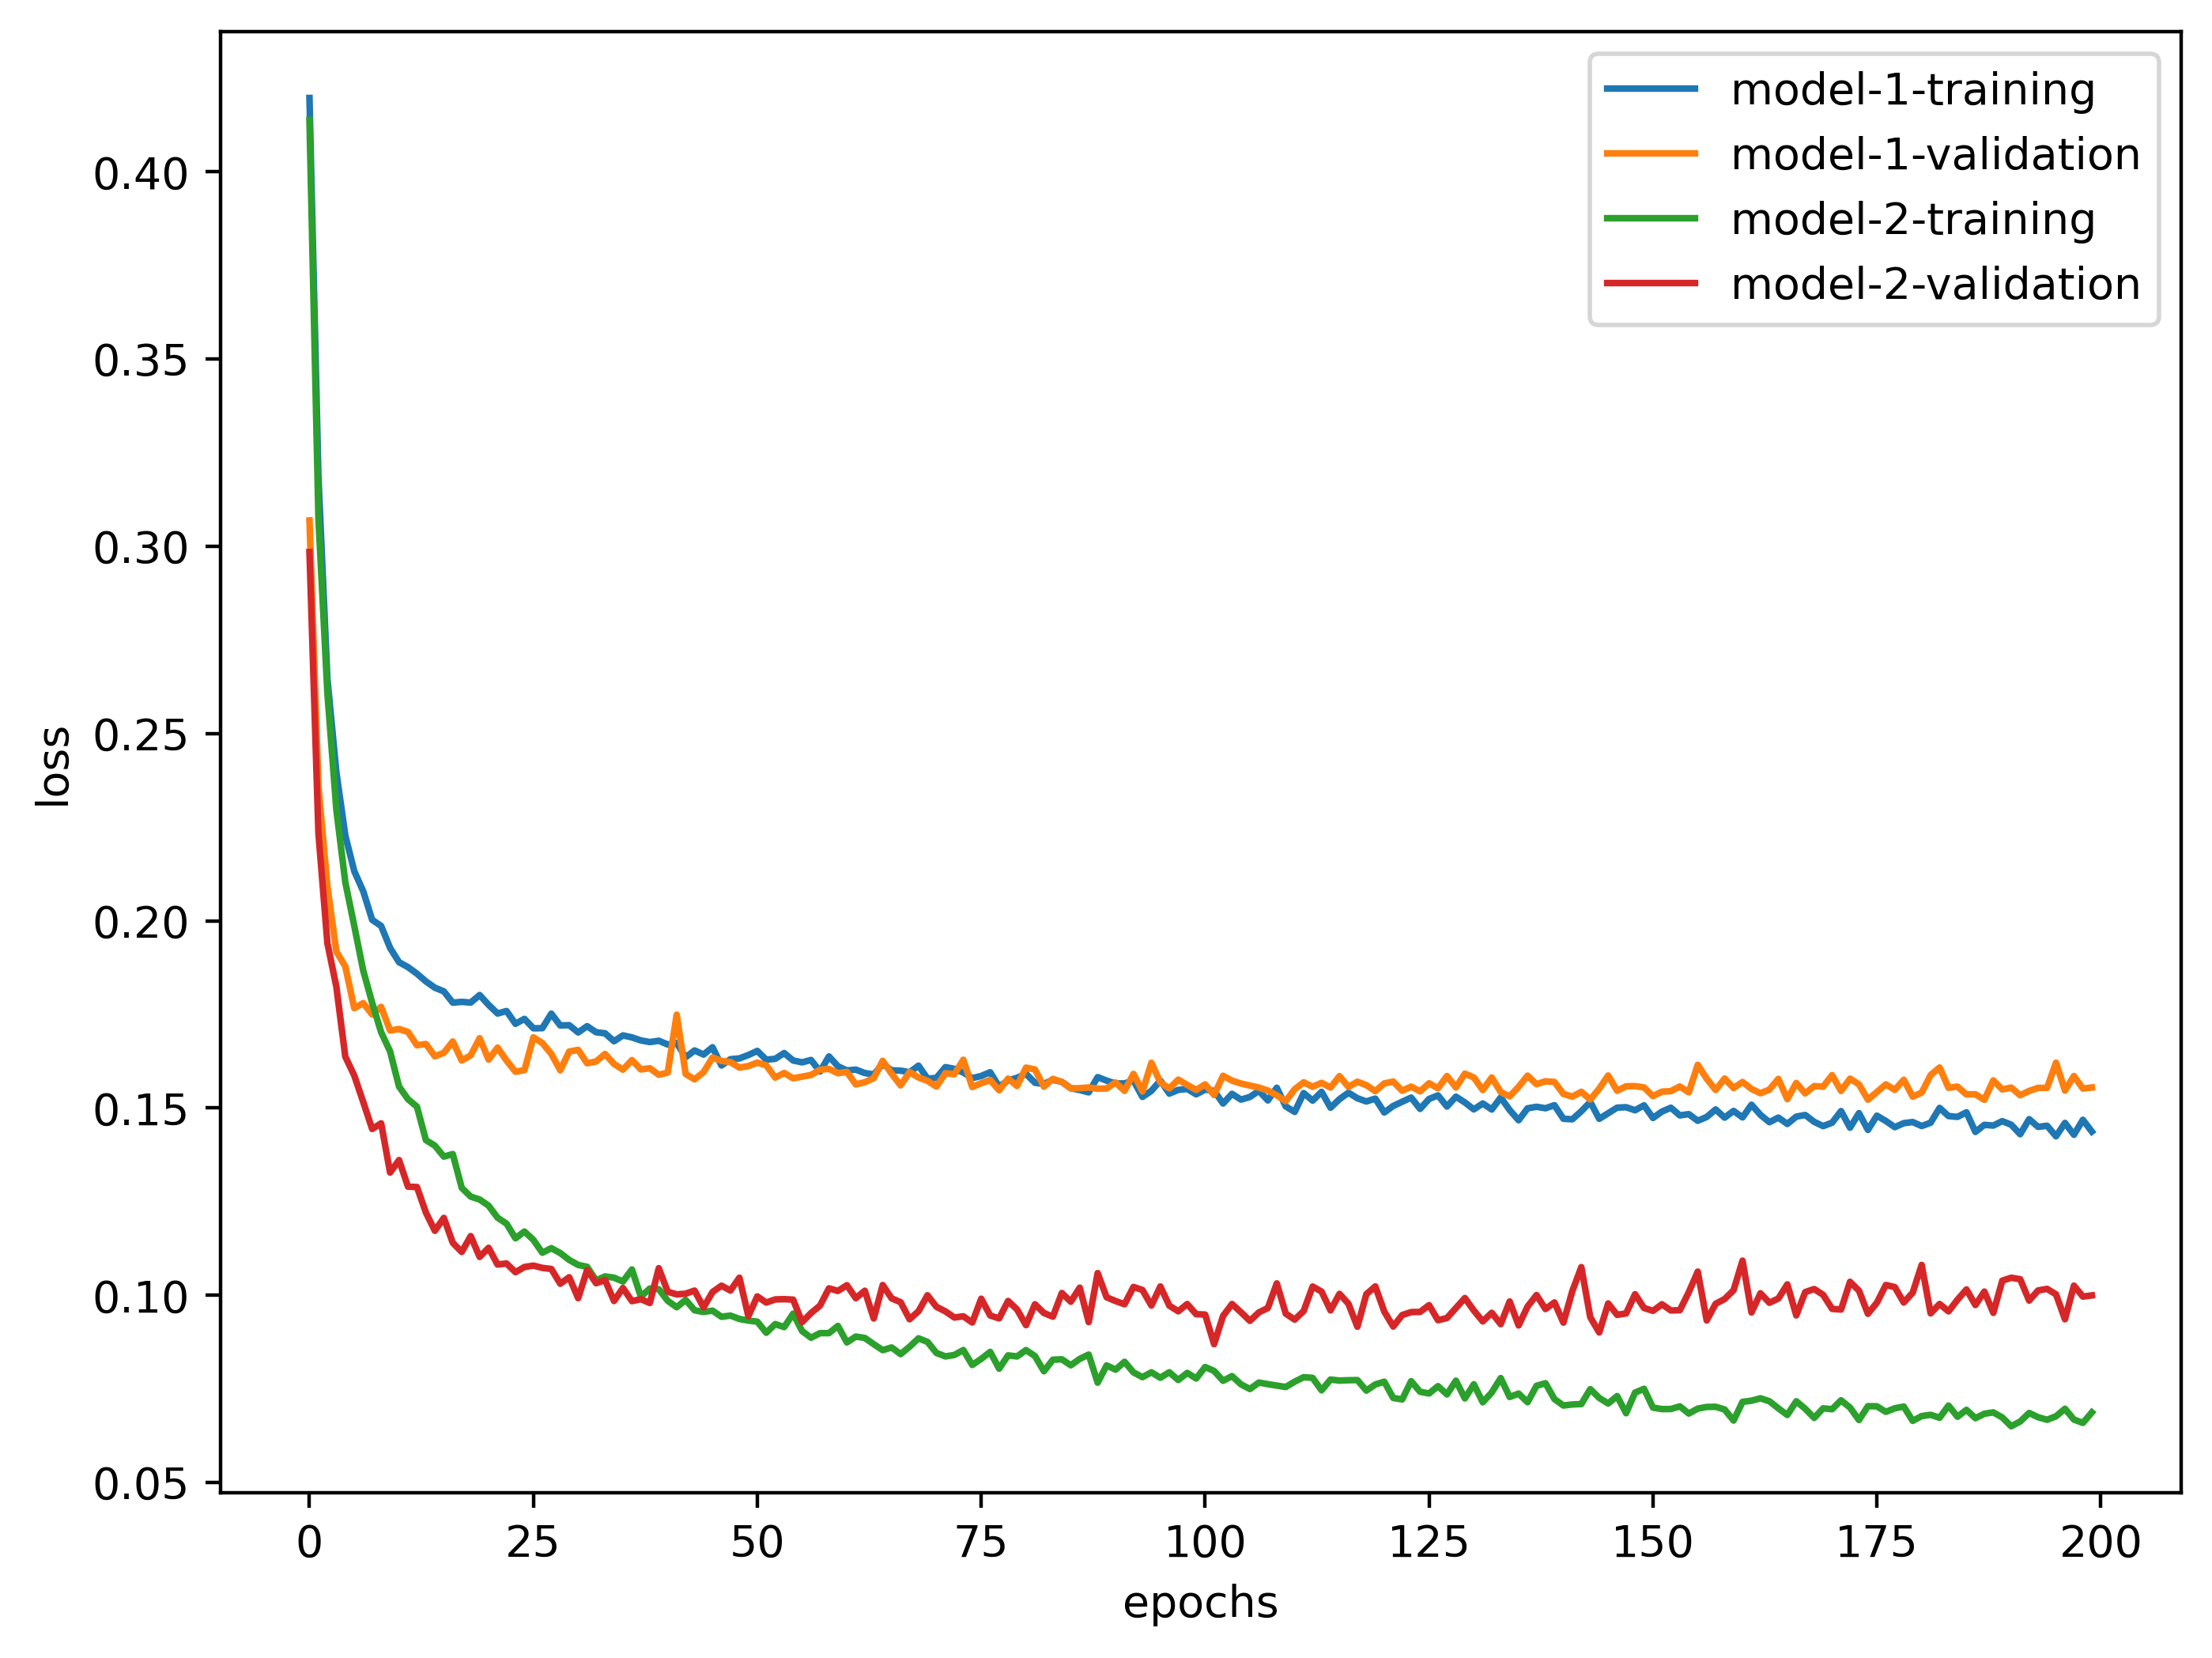

In [80]:
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(history_1.history['loss'], label='model-1-training')
plt.plot(history_1.history['val_loss'], label='model-1-validation')
plt.plot(history_2.history['loss'], label='model-2-training')
plt.plot(history_2.history['val_loss'], label='model-2-validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()


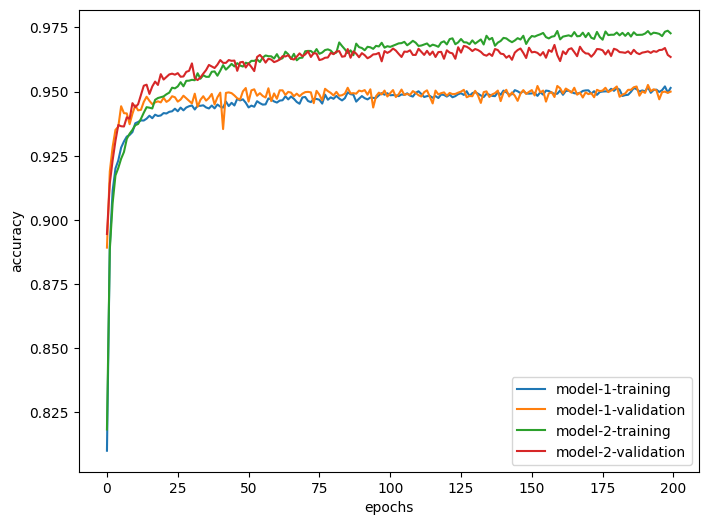

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['binary_accuracy'], label='model-1-training')
plt.plot(history_1.history['val_binary_accuracy'], label='model-1-validation')
plt.plot(history_2.history['binary_accuracy'], label='model-2-training')
plt.plot(history_2.history['val_binary_accuracy'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()


# b) Đánh giá trên tập test

In [82]:
model_1.load_weights(model_dir + '/Best-model-1.h5')
model_2.load_weights(model_dir + '/Best-model-2.h5')

loss_1, accuracy_1 = model_1.evaluate(x_test_normal, y_test)
loss_2, accuracy_2 = model_2.evaluate(x_test_one_hot, y_test)

print("Model-1: {}%\nModel-2: {}%".format(accuracy_1, accuracy_2))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9527 - loss: 0.1502
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9657 - loss: 0.0990
Model-1: 0.9503999948501587%
Model-2: 0.9660999774932861%


# c) Pokémon PK (dự đoán đối đầu)

In [83]:
venusaur  = np.expand_dims(pokemon_data_one_hot[3], axis=0)    # Wonderful frog flower
charizard = np.expand_dims(pokemon_data_one_hot[7], axis=0)    # Spitfire Dragon
blastoise = np.expand_dims(pokemon_data_one_hot[12], axis=0)   # Water Arrow Turtle

pred = model_2.predict(np.concatenate([venusaur, charizard], axis=-1))
winner = 'Wonderful frog flower' if pred < 0 else 'Spitfire Dragon'
print("pred={}, {} wins".format(pred, winner))

pred = model_2.predict(np.concatenate([charizard, blastoise], axis=-1))
winner = 'Spitfire Dragon' if pred < 0 else 'Water Arrow Turtle'
print("pred={}, {} wins".format(pred, winner))

pred = model_2.predict(np.concatenate([blastoise, venusaur], axis=-1))
winner = 'Water Arrow Turtle' if pred < 0 else 'Wonderful frog flower'
print("pred={}, {} wins".format(pred, winner))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
pred=[[11.187751]], Spitfire Dragon wins
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pred=[[-15.352096]], Spitfire Dragon wins
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
pred=[[7.929089]], Wonderful frog flower wins
